# Prepare data for training dataframe

NOTE: This notebook is not finished. The work was aborted when it turned out that the resulting dataset is highly imbalanced. For adjusted and finished version, see the other data_prep notebook.

The aim is to produce a table where each `order_id` is mapped to all coupons available on the date the order was made, along with information (`True`/`False`) if the coupon was used in that order.

The steps are as follows:
1. Based on the `coupons` table, create a `coupon_dates` dataframe which maps a date to all coupons available on that date.
2. Merge `coupon_dates` with `orders` in order to create a dataframe mapping `order_id` to all coupons available on the date that order was made -> `order_coupons_available`
3. From the `order_details` table, select only `order_id` - `coupon_id` pairs, resulting in `order_coupons_used` - a dataframe mapping an order to the coupons used in that order, if any.
4. Combine `order_coupons_available` and `order_coupons_used`, add column `coupon_used` which stores `True` for coupons used in an order, and `False` for coupons not used in an order.

In [27]:
import datetime
import os

from IPython.display import Image
import numpy as np
import pandas as pd

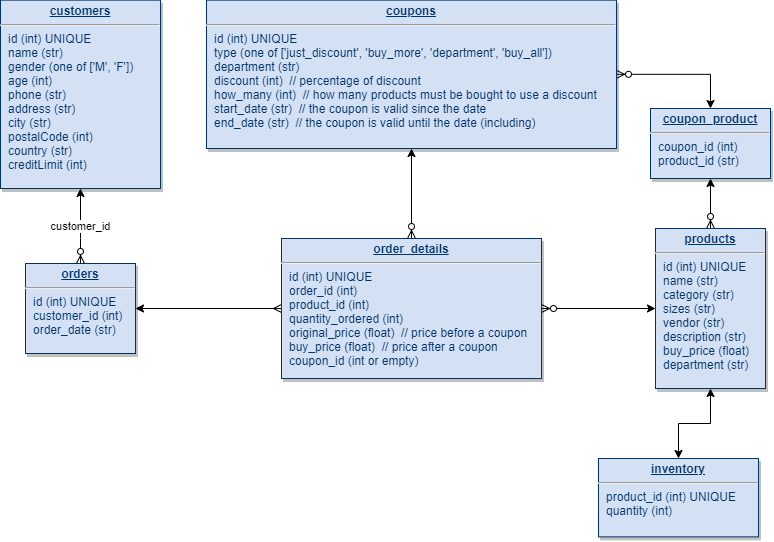

In [28]:
Image('data_diagram.png')

In [2]:
data_dir = 'data_0407_0'

#### Step 1. Based on the `coupons` table, create a `coupon_dates` dataframe which maps a date to all coupons available on that date.

In [3]:
coupons = pd.read_csv(os.path.join(data_dir, 'coupons.csv'))
coupons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1688 non-null   int64 
 1   type        1688 non-null   object
 2   department  77 non-null     object
 3   discount    1688 non-null   int64 
 4   how_many    1688 non-null   int64 
 5   start_date  1688 non-null   object
 6   end_date    1688 non-null   object
dtypes: int64(3), object(4)
memory usage: 92.4+ KB


In [4]:
coupons.sample(5)

,id,type,department,discount,how_many,start_date,end_date
90,91,buy_more,NaN,18,3,2010-02-16,2010-03-15
1072,1073,buy_more,NaN,50,3,2011-12-01,2011-12-25
646,647,buy_more,NaN,38,5,2011-02-27,2011-03-08
1034,1035,buy_more,NaN,16,2,2011-11-04,2011-11-14
1291,1292,just_discount,NaN,27,1,2012-04-18,2012-05-17


In [5]:
coupons.start_date = pd.to_datetime(coupons.start_date, format='%Y-%m-%d')
coupons.end_date = pd.to_datetime(coupons.end_date, format='%Y-%m-%d')
coupons.rename(columns={'id': 'coupon_id'}, inplace=True)

In [6]:
coupon_dates = coupons.drop(['type', 'department', 'discount', 'how_many'], axis=1)

In [7]:
# Get the earliest and latest date in the dataset
start = coupon_dates.start_date.min()
end = coupon_dates.end_date.max()
days = (end-start).days + 1
print(f'Start: {start.date()}, end: {end.date()}. {days} days')

Start: 2010-01-01, end: 2013-01-24. 1120 days


In [8]:
# Create a dataframe with row for each day from the earliest to the latest date in the set
all_dates = pd.DataFrame(pd.date_range(start=start, end=end, freq='D'), columns=['date'])
assert days == len(all_dates)

In [9]:
# Step 1.1: Perform a cross join of `all_dates` and `coupon_dates` - which contains info on validity periods
coupon_dates['key'] = 1
all_dates['key'] = 1
coupon_dates = pd.merge(coupon_dates, all_dates, on='key').drop('key', axis=1)

# Step 1.2 Drop rows where a date does not fall within the validity period of a coupon
coupon_dates = coupon_dates[(coupon_dates['date'] >= coupon_dates['start_date']) & \
                            (coupon_dates['date'] <= coupon_dates['end_date'])]
coupon_dates.drop(['start_date', 'end_date'], axis=1, inplace=True)
coupon_dates

,coupon_id,date
0,1,2010-01-01
1,1,2010-01-02
2,1,2010-01-03
3,1,2010-01-04
4,1,2010-01-05
...,...,...
1890540,1688,2013-01-05
1890541,1688,2013-01-06
1890542,1688,2013-01-07
1890543,1688,2013-01-08


In [10]:
coupon_dates.date = coupon_dates.date.dt.date

In [11]:
# Validate date_coupon is consistent with the original data in terms of coupon validity dates
coupons['days_valid'] = (coupons.end_date - coupons.start_date).dt.days + 1
df = pd.merge(coupons, coupon_dates.groupby(by='coupon_id').count().rename(columns={'date': 'days_valid'}), on='coupon_id')
assert 0 == len(df.loc[df.days_valid_x != df.days_valid_y])
coupons.drop(['days_valid'], axis=1, inplace=True)

# Validate no coupon has been lost
assert len(coupons) == len(coupon_dates.coupon_id.unique())

In [12]:
coupon_dates.groupby('date').count().median()

coupon_id    24.0
dtype: float64

#### Step 2. Merge `coupon_dates` with `orders` in order to create a dataframe mapping `order_id` to all coupons available on the date that order was made -> `order_coupons_available`

In [13]:
orders = pd.read_csv(os.path.join(data_dir, 'orders.csv'))
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324683 entries, 0 to 324682
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           324683 non-null  int64 
 1   customer_id  324683 non-null  int64 
 2   order_date   324683 non-null  object
dtypes: int64(2), object(1)
memory usage: 7.4+ MB


In [14]:
orders.sample(5)

,id,customer_id,order_date
321942,321943,111,2012-12-21 16:46:04
259661,259662,544,2012-05-27 12:58:35
263595,263596,637,2012-06-09 13:50:04
76819,76820,856,2010-09-16 10:39:13
439,440,776,2010-01-02 13:10:04


In [15]:
orders.rename(columns={'id': 'order_id', 'order_date': 'date'}, inplace=True)
orders.date = pd.to_datetime(orders.date, format='%Y-%m-%d').dt.date

In [16]:
order_coupons_available = pd.merge(coupon_dates, orders[['order_id', 'date']], on='date', how='left')\
                            .dropna().drop(['date'], axis=1)

In [17]:
order_coupons_available

,coupon_id,order_id
0,1,1.0
1,1,2.0
2,1,3.0
3,1,4.0
4,1,5.0
...,...,...
7624415,1688,324679.0
7624416,1688,324680.0
7624417,1688,324681.0
7624418,1688,324682.0


#### Step 3. From the `order_details` table, select only `order_id` - `coupon_id` pairs, resulting in `order_coupons_used` - a dataframe mapping an order to the coupons used in that order, if any.

In [18]:
order_details = pd.read_csv(os.path.join(data_dir, 'order_details.csv'))
order_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395354 entries, 0 to 2395353
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                int64  
 1   order_id          int64  
 2   product_id        int64  
 3   quantity_ordered  int64  
 4   original_price    float64
 5   buy_price         float64
 6   coupon_id         float64
dtypes: float64(3), int64(4)
memory usage: 127.9 MB


In [19]:
order_details.sample(5)

,id,order_id,product_id,quantity_ordered,original_price,buy_price,coupon_id
1078232,1078233,145447,1962,5,4.01,1.7243,734.0
1463383,1463384,196697,2168,18,2.03,2.0300,NaN
1597884,1597885,215224,584,2,4.07,1.3431,1101.0
73244,73245,10317,1374,5,12.18,4.6284,46.0
680560,680561,92155,1864,2,2.65,2.6500,NaN


In [20]:
order_details.drop(['id'], axis=1, inplace=True)

In [21]:
order_coupon_used = order_details[['order_id', 'coupon_id']].dropna().drop_duplicates()

In [22]:
order_coupon_used

,order_id,coupon_id
2,3,7.0
4,3,22.0
10,6,3.0
14,7,8.0
17,7,7.0
...,...,...
2395344,324681,1682.0
2395345,324681,1672.0
2395351,324682,1677.0
2395352,324682,1682.0


#### Step 4. Combine `order_coupons_available` and `order_coupons_used`, add column `coupon_used` which stores `True` for coupons used in an order, and `False` for coupons not used in an order.

In [23]:
order_coupon_used.set_index(['order_id', 'coupon_id'], inplace=True)
order_coupons_available.set_index(['order_id', 'coupon_id'], inplace=True)

In [24]:
order_coupons_available['coupon_used'] = order_coupons_available.index.isin(order_coupon_used.index)

In [25]:
order_coupons = order_coupons_available.reset_index()

In [26]:
order_coupons.coupon_used.value_counts(normalize=True)

False    0.947504
True     0.052496
Name: coupon_used, dtype: float64